## Experiment 3: Quark Gluon
- 20000 samples
- Train pairs: (36000, 2, 40, 40)
- Test pairs:  (4000, 2, 40, 40)
- using only 1 channel, 4th channel
- Data: cropping, normalisation, pair creation
- Model: Base CNN + Qnn layers
- Loss: contrastive margin pair loss
- Siamese Network
- Training epochs 20, batch size 128, loss: 0.2 approx

### Imports and Data loading

In [1]:
# Required imports
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, initializers

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as cmatrix

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# d = np.load('../../data/quark_gluon_dataset/quark_gluon_20000_1.npz', allow_pickle=True)
# x_train = d["x_train"]
# y_train = d["y_train"]
# x_test = d["x_test"]
# y_test = d["y_test"]

In [3]:
# import matplotlib.pyplot as plt

# def plot_image_grid(data, label, filter_label=None, channel=0, rows=5, cols=5):
#     # Filter the data and labels if filter_label is provided
#     if filter_label is not None:
#         indices = [i for i, l in enumerate(label) if l == filter_label]
#         filtered_data = data[indices]
#         filtered_label = label[indices]
#     else:
#         filtered_data = data
#         filtered_label = label

#     fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
#     for i in range(rows):
#         for j in range(cols):
#             idx = i * cols + j
#             if idx < len(filtered_data):
#                 axes[i, j].imshow(filtered_data[idx,:,:,channel])
#                 axes[i, j].title.set_text(f'{filtered_label[idx]}')
#             axes[i, j].axis('off')

#     plt.show()

In [4]:
# plot_image_grid(x_train, y_train, filter_label=0,channel=1)

In [5]:
# plot_image_grid(x_train, y_train, filter_label=1,channel=1)

In [6]:
# plot_image_grid(x_train, y_train, filter_label=0,channel=2)

In [7]:
# plot_image_grid(x_train, y_train, filter_label=1,channel=2)

In [2]:
data = np.load('../../data/quark_gluon_dataset/qg_20000_pairs_c4.npz', allow_pickle=True)

pairs_train = data["pairs_train"]
labels_train = data["labels_train"]
pairs_test = data["pairs_test"]
labels_test = data["labels_test"]

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape, labels_test.shape)

(36000, 2, 40, 40) (4000, 2, 40, 40)
(36000,) (4000,)


In [3]:
pairs_train = np.expand_dims(pairs_train, -1)
pairs_test = np.expand_dims(pairs_test, -1)
print(pairs_train.shape)

(36000, 2, 40, 40, 1)


In [4]:
def plot_sample_pairs(pairs, labels, shape, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(shape, shape))
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(shape, shape))
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

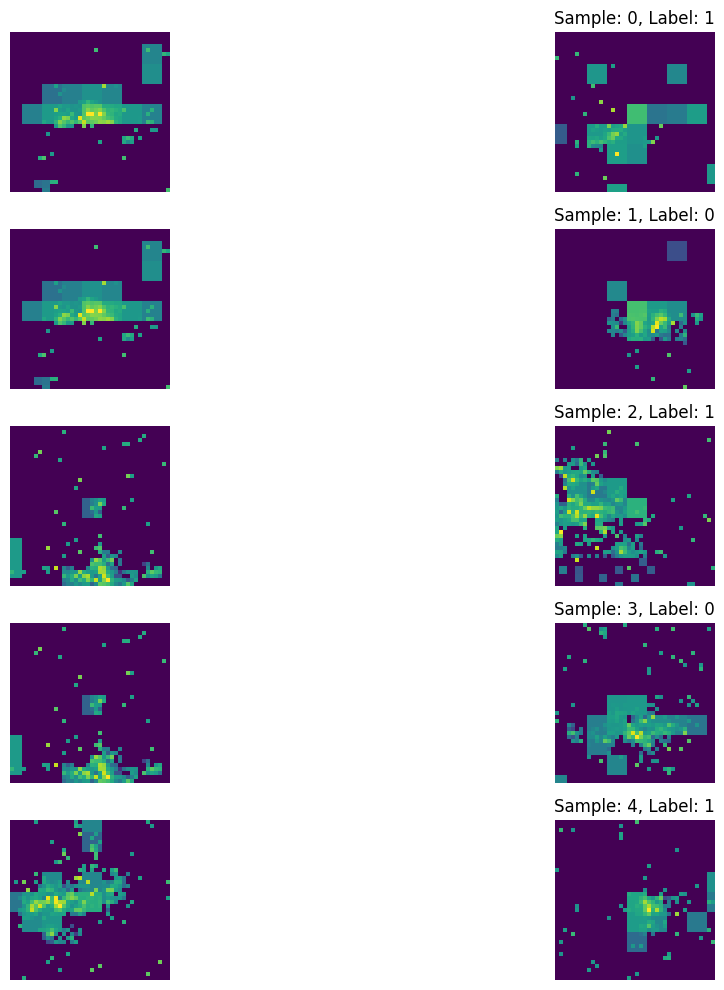

In [5]:
plot_sample_pairs(pairs_train, labels_train, shape=40, num_samples=5)

### Quantum Layer

In [22]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

# Quantum device
n_qubits = 12
n_layers = 3
n_ancillas = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum layers
def H_layer(n_qubits, n_ancillas):
    for idx in range(n_ancillas, n_qubits):  # 0th qubits reserved for ancilla purposes
        qml.Hadamard(wires=idx)

def RY_layer(w, n_ancillas):
    """Layer of parameterized qubit rotations around the y axis."""
    for idx, element in enumerate(w, start=n_ancillas):  # 1st qubit is ancilla, used for SWAP test here.
        qml.RY(element, wires=idx)

def entangling_layer(nqubits, n_ancillas):
    """Layer of CNOTs followed by another shifted layer of CNOT."""
    for i in range(n_ancillas, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(n_ancillas + 1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, q_weights_flat, q_depth, n_qubits, n_ancillas):
    # Reshape weights
    q_weights = tf.reshape(q_weights_flat, (q_depth, n_qubits - n_ancillas))
    
    # Apply Hadamard layer
    H_layer(n_qubits, n_ancillas)
    
    # Embed features in the quantum node
    RY_layer(inputs, n_ancillas)
    
    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits, n_ancillas)
        RY_layer(q_weights[k], n_ancillas)
    
    return [qml.expval(qml.PauliZ(w)) for w in range(n_ancillas, n_qubits)]


### Model

In [25]:
from tensorflow.keras import layers, models

# Define trainable weights for the quantum circuit (will be used in training)
weight_shapes = {"q_weights_flat": (n_layers * (n_qubits - n_ancillas))}
quantum_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits - n_ancillas)

# Base model from classical nb, adding qlayer in between
def create_quantum_cnn(input_shape, return_embeddings=False):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))  # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Conv layer 2
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # ------ Quantum layer added in nb 2 classical base architecture
    # Reducing dimensions to match n_qubits
    model.add(layers.Dense(n_qubits - n_ancillas)) 
    # Quantum layer
    model.add(quantum_layer)
    # Dense layer after quantum layer
    model.add(layers.Dense(n_qubits - n_ancillas, activation='relu'))
    if return_embeddings:
        return model
    # --------------------------------------------------------------
    
    # model.add(layers.Dense(1, activation='sigmoid'))  
    return model

def quantum_fidelity(a, b):
    return tf.reduce_sum(a * b, axis=-1) ** 2

def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        pos_fidelity = quantum_fidelity(dist[:, 0], dist[:, 1])
        neg_fidelity = quantum_fidelity(dist[:, 0], dist[:, 2])
        return tf.reduce_mean(y_true * (1 - pos_fidelity) + (1 - y_true) * tf.maximum(margin - neg_fidelity, 0))
    return loss

def create_siamese_network(input_shape):
    base_model = create_quantum_cnn(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)
    processed_2 = base_model(input_2)

    output = tf.stack([processed_0, processed_1, processed_2], axis=1)

    siamese_model = models.Model([input_0, input_1, input_2], output)

    return siamese_model, base_model


ValueError: Must specify a shape for every non-input parameter in the QNode

In [15]:
# def simclr_loss():
#     def loss(z_real, z_estimate):
#         # The z_real parameter is not used since SimCLR is an unsupervised model.
#         # This dummy variable is discarded.
#         # del z_real
    
#         # Temperature parameter is set to 0.1. This hyperparameter can be tuned
#         # for specific problems to control the smoothness of the output distribution.
#         toe = .1
    
#         # Calculate the number of projections, which is twice the batch size (2N).
#         num = z_estimate.shape[0]
    
#         # Generate two sets of indices for all possible pair combinations within the batch.
#         # ind0 is a temporary variable holding the repeated range for generating indices.
#         ind0 = tf.repeat(tf.expand_dims(tf.range(0, num), axis=0), num, axis=0)
#         # Flatten ind0 to create a single list of indices for the first element of pairs.
#         ind1 = tf.reshape(ind0, (num**2, 1))[:, 0]
#         # Flatten the transpose of ind0 to create a single list of indices for the second element of pairs.
#         ind2 = tf.reshape(tf.transpose(ind0), (num**2, 1))[:, 0]
    
#         # The temporary index tensor is no longer needed after use.
#         del ind0
    
#         # Select the projections based on the first set of indices to form the first elements of pairs.
#         vector_1 = tf.gather(z_estimate, ind1, axis=0)
#         # The first set of indices is no longer needed after use.
#         del ind1
    
#         # Select the projections based on the second set of indices to form the second elements of pairs.
#         vector_2 = tf.gather(z_estimate, ind2, axis=0)
#         # The second set of indices is no longer needed after use.
#         del ind2
    
#         # Calculate the cosine similarity between each pair of projections and negate it to prepare for loss calculation.
#         s = -tf.reshape(tf.keras.losses.cosine_similarity(vector_1, vector_2, axis=1), (num, num))
    
#         # The vector tensors are no longer needed after computing similarities.
#         del vector_1
#         del vector_2
    
    
#         # Calculate the nominator of the contrastive loss function for each pair.
#         nom = tf.exp(s / toe)
    
#         # Calculate the denominator of the contrastive loss function by excluding the self-similarity term.
#         x1 = tf.exp(s / toe)
#         x2 = 1 - tf.eye(num, dtype=tf.float32)
#         denom = tf.repeat(tf.expand_dims(tf.math.reduce_sum(x1 * x2, axis=1), axis=1), num, axis=1)
    
#         # The intermediate tensors used for the denominator are no longer needed.
#         del s
#         del x1
#         del x2
    
#         # Calculate the loss `l(i, j)` for each pair of projections using the computed nominator and denominator.
#         l = -tf.math.log(nom / denom)
    
#         # Cleanup intermediate tensors to save memory.
#         del nom
#         del denom
    
#         # Prepare indices to extract the diagonal elements from the loss matrix, which correspond to the actual pair losses.
#         ind_2k0 = tf.range(0, num, 2, dtype=tf.int32)  # Even indices
#         ind_2k1 = tf.range(1, num, 2, dtype=tf.int32)  # Odd indices
    
#         # Extract and sum the losses for the actual pairs using the prepared indices.
#         loss_mat1_1 = tf.gather(l, ind_2k0, axis=0)
#         loss_mat1_2 = tf.gather(loss_mat1_1, ind_2k1, axis=1)
#         loss_mat1 = tf.linalg.diag_part(loss_mat1_2)
    
#         loss_mat2_1 = tf.gather(l, ind_2k1, axis=0)
#         loss_mat2_2 = tf.gather(loss_mat2_1, ind_2k0, axis=1)
#         loss_mat2 = tf.linalg.diag_part(loss_mat2_2)
    
#         # After extracting the necessary elements, the large loss tensor can be discarded.
#         del l
    
#         # Combine the individual loss components into a single tensor.
#         loss_mat = loss_mat1 + loss_mat2
    
#         # Compute the final loss by taking the sum over all individual losses and normalizing by the number of pairs.
#         L = tf.math.reduce_sum(loss_mat) / num
    
    
#         # Return the final computed loss.
#         return L
#     return loss

### Training

In [17]:
# Training
tf.get_logger().setLevel('ERROR')

# checkpoint_path = "hybrid_cnn_base_1_ep/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='hybrid_model_qg1_c2.h5', save_weights_only=True,verbose=1)


input_shape = pairs_train.shape[2:]
siamese_network, base_model = create_siamese_network(input_shape)

siamese_network.compile(loss=simclr_loss(), optimizer=optimizers.Adam(learning_rate=1e-3))

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=20,
    batch_size=128,
    callbacks=[cp_callback]
)

Epoch 1/20


InvalidArgumentError: in user code:

    File "C:\Users\Sanya Nanda\AppData\Local\Temp\ipykernel_33700\1881263787.py", line 36, in loss  *
        s = -tf.reshape(tf.keras.losses.cosine_similarity(vector_1, vector_2, axis=1), (num, num))
    File "C:\Users\Sanya Nanda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 2838, in cosine_similarity
        y_true = tf.linalg.l2_normalize(y_true, axis=axis)

    InvalidArgumentError: {{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:CPU:0}} Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Sum] name: 


In [16]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 8)                    1203240   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

<Axes: title={'center': 'Learning History'}>

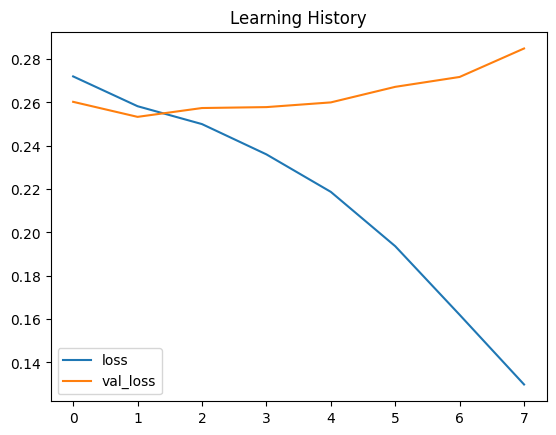

In [17]:
pd.DataFrame(history.history).plot(title="Learning History")

### Embeddings

In [18]:
embedding_model = models.Model(inputs=base_model.input, outputs=base_model.output)

# Use the model to predict (get embeddings) for new data
embeddings = embedding_model.predict(x_test[:,:,:,0])

# Example: fetching embeddings for the training data
print(embeddings.shape)

NameError: name 'x_test' is not defined

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

df = pd.DataFrame(embeddings_3d, columns=['tsne1', 'tsne2', 'tsne3'])
df['label'] = y_test

# Visualize the 3D embeddings
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red' if label == 1 else 'blue' for label in y_test]
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors)
ax.set_title('3D t-SNE visualization of Quark Gluon embeddings')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
plt.show()

### Model Evaluation

In [ ]:
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

y_pred = distances_to_labels(distance)

In [ ]:
from helpers import evaluate_precision_recall_accuracy
evaluate_precision_recall_accuracy(labels_test,y_pred)

In [ ]:
from helpers import plot_auc

In [ ]:
plot_auc(labels_test,y_pred)